In [2]:
import torch
import torch.nn as nn
import torchvision
from torchvision import models #torchvision consists of many popular datasets
import torchvision.models.vgg as models
from torchvision import datasets, transforms
import torch.optim as optim
from torch.autograd import Variable # for caculating gradients

import numpy as np
import torch.nn.functional as F

import matplotlib.pyplot as plt
from PIL import Image

from utils.ShipDataset import get_ship_dataset, load_image
from utils.Training import TrainingHelper, PlotReporter, ConsoleReporter

In [3]:
pretrained_model = models.vgg16(pretrained=True) #load pretrained model
feature = torch.nn.Sequential(*list(pretrained_model.children())[:])
print(feature)

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [4]:
batch_size = 32 #50
learning_rate = 0.0002 #0.02
epoch = 10 #5

In [5]:

train_dataset, valid_dataset = get_ship_dataset("./dataset/class", 10000, validation=0.1)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True) #16,50
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=64, shuffle=False)

In [6]:
images, labels = next(iter(train_loader))
print(images.size())

torch.Size([32, 3, 80, 80])


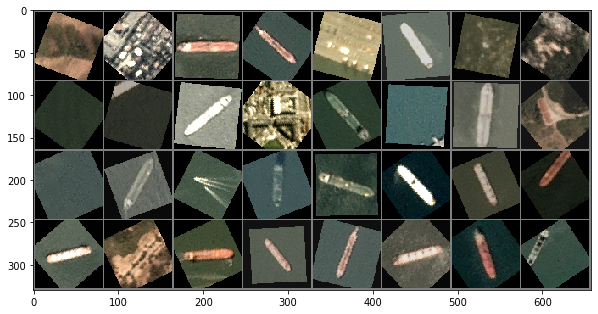

In [7]:
images, labels = next(iter(train_loader))

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

imshow(torchvision.utils.make_grid(images))

In [8]:
#Transfer learning VGG16
class VGGNet(nn.Module):
    def __init__(self, num_classes=1):   #num_classes,  classification
        super(VGGNet, self).__init__()
        pretrained_model = models.vgg16(pretrained=True)  #load pretrained feature
        pretrained_model.classifier = nn.Sequential() # Empty the classification layer
        self.features = pretrained_model  #keep VGG16 features
        self.classifier = nn.Sequential(    #define classifier layer for shiprecognition
                nn.Linear(512 * 7 * 7, 512),  #512 * 7 * 7 can't be changed, it's decided by VGG16.The Second parameter 512 is the number of nodes, it can be fine tuned.
                nn.ReLU(True),
                nn.Dropout(),
                nn.Linear(512, 128),
                nn.ReLU(True),
                nn.Dropout(),
                nn.Linear(128, num_classes),
                nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x
#         return x.view(-1, 1)


In [9]:
vggnet = VGGNet()
feature_vgg = torch.nn.Sequential(*list(vggnet.children())[:])
print(feature_vgg)

Sequential(
  (0): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16): M

In [10]:
vggnet = VGGNet()
#inputs, labels1 = next(iter(train_loader))
inputs=torch.randn(1,3,80,80)
print(inputs.size())
output = vggnet(inputs)
print(output)

torch.Size([1, 3, 80, 80])
tensor([[0.5483]], grad_fn=<SigmoidBackward>)


In [11]:
# train
vggnet = VGGNet()

# if torch.cuda.is_available():
#     vggnet.cuda() #move the model to GPU 
    
params = [{'params': md.parameters()} for md in vggnet.children()
          if md in [vggnet.classifier]] #??????????

optimizer = optim.Adam(vggnet.parameters(), lr=learning_rate)
# loss_function = nn.CrossEntropyLoss()

# Loss_list = []
# Accuracy_list = []

inputs, labels = next(iter(train_loader))

loss_function = nn.BCELoss()
#loss = loss_function(output, label)
#print(loss.item())

vggnet.train()
for i in range(epoch):
#     print('epoch {}'.format(i + 1))
    train_loss = 0.
    train_acc = 0.
    for inputs, label in train_loader:
#         inputs = Variable(inputs).cuda()
        inputs = Variable(inputs)
#         label = Variable(label).cuda()
        label = Variable(label)
        optimizer.zero_grad()
        output = vggnet(inputs)   
        loss = loss_function(output, label)
        train_loss += loss.item()
        #pred = torch.max(output, 1)[1] #torch.max(out, 1) 0-每一列最大的  1-每一行最大的  生成两个数组 一个数值 一个序号
        #train_correct = (pred == label).sum()
        #train_acc += train_correct.data[0]
        loss.backward()
        optimizer.step()

    Loss = float(train_loss / (len(train_datasets)))
    #Acc = float(train_acc / (len(train_datasets)))
#     print("Train Loss:%.9f" % Loss)
#     print("Acc:%.9f" % Acc)
    print('epoch {} | Train Loss:{:.3f}'.format(i+1, Loss))

#     print('epoch {} | Train Loss:{:.3f} | Acc:{:.3f}'.format(i+1, Loss, Acc))
print('done')




KeyboardInterrupt: 

In [30]:
# train
vggnet = VGGNet()

# if torch.cuda.is_available():
#     vggnet.cuda() #move the model to GPU 
    
params = [{'params': md.parameters()} for md in vggnet.children()
          if md in [vggnet.classifier]] #??????????

optimizer = optim.Adam(vggnet.parameters(), lr=learning_rate)
# loss_function = nn.CrossEntropyLoss()
loss_function = nn.BCELoss()

# Loss_list = []
# Accuracy_list = []

vggnet.train()
inputs, labels1 = next(iter(train_loader))
output = vggnet(inputs)
print(output)
print(labels1)
print(output.size(),labels1.size())
# labels1 = labels1.long()
loss = loss_function(output, labels1)
# for i in range(epoch):
# #     print('epoch {}'.format(i + 1))
#     train_loss = 0.
#     train_acc = 0.
'''
    for inputs, label in train_loader:
#         inputs = Variable(inputs).cuda()
        inputs = Variable(inputs)
#         label = Variable(label).cuda()
        label = Variable(label)
        optimizer.zero_grad()
        output = vggnet(inputs)
        loss = loss_function(output, label)
        train_loss += loss.data[0]
        pred = torch.max(output, 1)[1] #torch.max(out, 1) 0-每一列最大的  1-每一行最大的  生成两个数组 一个数值 一个序号
        train_correct = (pred == label).sum()
        train_acc += train_correct.data[0]
        loss.backward()
        optimizer.step()

    Loss = float(train_loss / (len(train_datasets)))
    Acc = float(train_acc / (len(train_datasets)))
#     print("Train Loss:%.9f" % Loss)
#     print("Acc:%.9f" % Acc)
    print('epoch {} | Train Loss:{:.3f} | Acc:{:.3f}'.format(i +1, Loss, Acc))
    print('done')
'''


tensor([[0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.1173],
        [0.1325],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.1006],
        [0.0345],
        [0.0000],
        [0.0639],
        [0.1023],
        [0.1640],
        [0.0000],
        [0.0711],
        [0.0000],
        [0.0000],
        [0.0615],
        [0.2199],
        [0.0000],
        [0.3151],
        [0.1512],
        [0.0000],
        [0.0393],
        [0.0685],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000]], grad_fn=<ReluBackward1>)
tensor([[1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
      

'\n    for inputs, label in train_loader:\n#         inputs = Variable(inputs).cuda()\n        inputs = Variable(inputs)\n#         label = Variable(label).cuda()\n        label = Variable(label)\n        optimizer.zero_grad()\n        output = vggnet(inputs)\n        loss = loss_function(output, label)\n        train_loss += loss.data[0]\n        pred = torch.max(output, 1)[1] #torch.max(out, 1) 0-每一列最大的  1-每一行最大的  生成两个数组 一个数值 一个序号\n        train_correct = (pred == label).sum()\n        train_acc += train_correct.data[0]\n        loss.backward()\n        optimizer.step()\n\n    Loss = float(train_loss / (len(train_datasets)))\n    Acc = float(train_acc / (len(train_datasets)))\n#     print("Train Loss:%.9f" % Loss)\n#     print("Acc:%.9f" % Acc)\n    print(\'epoch {} | Train Loss:{:.3f} | Acc:{:.3f}\'.format(i +1, Loss, Acc))\n    print(\'done\')\n'

In [ ]:
# train
vggnet = VGGNet()

if torch.cuda.is_available():
    vggnet.cuda() #move the model to GPU 
    
params = [{'params': md.parameters()} for md in vggnet.children()
          if md in [vggnet.classifier]] #??????????

optimizer = optim.Adam(vggnet.parameters(), lr=learning_rate)
loss_function = nn.CrossEntropyLoss()

# Loss_list = []
# Accuracy_list = []

vggnet.train()
for i in range(epoch):
#     print('epoch {}'.format(i + 1))
    train_loss = 0.
    train_acc = 0.
    for inputs, label in train_loader:
#         inputs = Variable(inputs).cuda()
        inputs = Variable(inputs)
#         label = Variable(label).cuda()
        label = Variable(label)
        optimizer.zero_grad()
        output = vggnet(inputs)
        loss = loss_function(output, label)
        train_loss += loss.item()
        pred = torch.max(output, 1)[1] #torch.max(out, 1) 0-每一列最大的  1-每一行最大的  生成两个数组 一个数值 一个序号
        train_correct = (pred == label).sum()
        train_acc += train_correct.data[0]
        loss.backward()
        optimizer.step()

    Loss = float(train_loss / (len(train_datasets)))
    Acc = float(train_acc / (len(train_datasets)))
#     print("Train Loss:%.9f" % Loss)
#     print("Acc:%.9f" % Acc)
    print('epoch {} | Train Loss:{:.3f} | Acc:{:.3f}'.format(i +1, Loss, Acc))
    print('done')


    
 

In [17]:
inputs, lables = next(iter(train_loader))
x = vggnet.forward(inputs)

# training = TrainingHelper(vggnet, nn.CrossEntropyLoss(), optim.Adam(vggnet.parameters(), lr=learning_rate))
# training.reporter = PlotReporter(figsize=(15,5))

# training.fit(10,train_loader,valid_loader)
training = TrainingHelper(vggnet, nn.BCELoss(), optim.Adam(vggnet.parameters(), lr=0.001))
training.reporter = PlotReporter(figsize=(15,5))
print(training.reporter)
#training.reporter = ConsoleReporter()
# training.fit(10,train_loader,valid_loader)

In [32]:
training.fit(30,train_loader,valid_loader)

RuntimeError: Assertion `x >= 0. && x <= 1.' failed. input value should be between 0~1, but got -0.191543 at /tmp/pip-req-build-9oilk29k/aten/src/THNN/generic/BCECriterion.c:60

In [ ]:
 training.fit(30,train_loader,valid_loader)